In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
from loaders import clean_text_for_pattern_letter
from temp_text_puh import template_str
# input_str = clean_text_for_pattern_letter(template_str, out_len=len(template_str))
input_str = clean_text_for_pattern_letter(template_str, out_len=10000)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
10000
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [39]:
def divide_via_distribution_old(input: list, buffer_size: int = 10):
    K: dict[str, int] = {}
    B: dict[str, int] = {}

    T = []

    # init K
    S_K = 0
    for inp_idx in range(buffer_size):
        inp = input[inp_idx]

        K.setdefault(inp, 0)
        K[inp] += 1

        S_K += 1

    # init buffer
    S_B = 0
    for inp_idx in range(buffer_size, buffer_size*2):
        inp = input[inp_idx]

        B.setdefault(inp, 0)
        B[inp] += 1

        S_B += 1

    for symbol, stats in B.items():
        B[symbol] = stats / S_B
    
    # main loop
    # for inp_idx, inp in enumerate(input):
    for i in range(buffer_size):
        T.append(0.5)

    inp_idx = buffer_size
    while inp_idx <= len(input) - (buffer_size * 2)-1:
        K_D = {}
        for symbol, stats in K.items():
            K_D.setdefault(symbol, stats / S_K)
        # print(f'{K_D=}')
    
        # compare
        diff_sum = 0
        for symbol, stats in K_D.items():
            buf_stats = B.get(symbol, 0)

            diff = abs(stats - buf_stats)
            diff_sum += diff

        for symbol, stats in B.items():
            if not K_D.get(symbol):
                diff_sum += stats

        # print(f'{diff_sum=}')
        T.append(diff_sum)

        # flush K if peak
        if T[inp_idx-1] > T[inp_idx - 2] and T[inp_idx-1] > T[inp_idx]:
            K = {}
            S_K = 0
            for i_idx in range(inp_idx, inp_idx + buffer_size):
                inpt = input[i_idx]

                K.setdefault(inpt, 0)
                K[inpt] += 1

                S_K += 1
            
            inp_idx += buffer_size
            for i in range(buffer_size):
                T.append(diff_sum)

        # update K
        inp = input[inp_idx]

        K.setdefault(inp, 0)
        K[inp] += 1
        S_K += 1

        # update buffer
        B = {}
        S_B = 0
        for i_idx in range(inp_idx+1, inp_idx+1 + buffer_size+1):
            inpt = input[i_idx]

            B.setdefault(inpt, 0)
            B[inpt] += 1

            S_B += 1
        
        for symbol, stats in B.items():
            B[symbol] = stats / S_B
        print(f'{B=}')

        # recur
        inp_idx += 1

    for i in range(buffer_size):
        T.append(0.5)
    print(f'{len(T)=}')
    return T


In [40]:
def divide_via_distribution(input: list, buffer_size: int = 10):
    D: list[dict[str, int]] = []
    T = []

    for inp_idx, inp in enumerate(input):
        if inp_idx >= len(input) - buffer_size:
            break

        B = {}
        S_B = 0
        for i_idx in range(inp_idx, inp_idx + buffer_size):
            inpt = input[i_idx]

            B.setdefault(inpt, 0)
            B[inpt] += 1

            S_B += 1
        
        for symbol, stats in B.items():
            B[symbol] = stats / S_B
        # print(f'{B=}')
        D.append(B)

    d = D[0]

    for idx_d, next_d in enumerate(D[1:]):
        if idx_d >= len(D) - 1:
            break

        next_d = D[idx_d+1]

        # compare
        diff_sum = 0
        for symbol, stats in d.items():
            buf_stats = next_d.get(symbol, 0)

            diff = abs(stats - buf_stats)
            diff_sum += diff

        for symbol, stats in next_d.items():
            if not d.get(symbol):
                diff_sum += stats

        T.append(diff_sum)
        
    return T

In [41]:
T = divide_via_distribution(input=input_str, buffer_size=2000)

In [42]:
def plot_T(T:list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)

    plt.show()

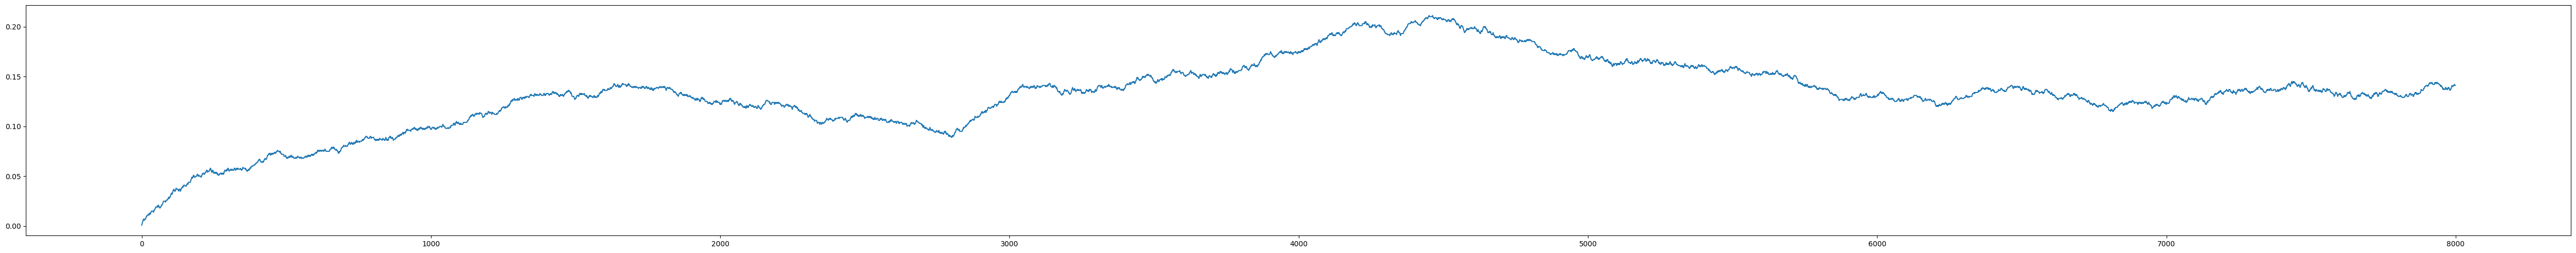

In [43]:
plot_T(T=T)

100


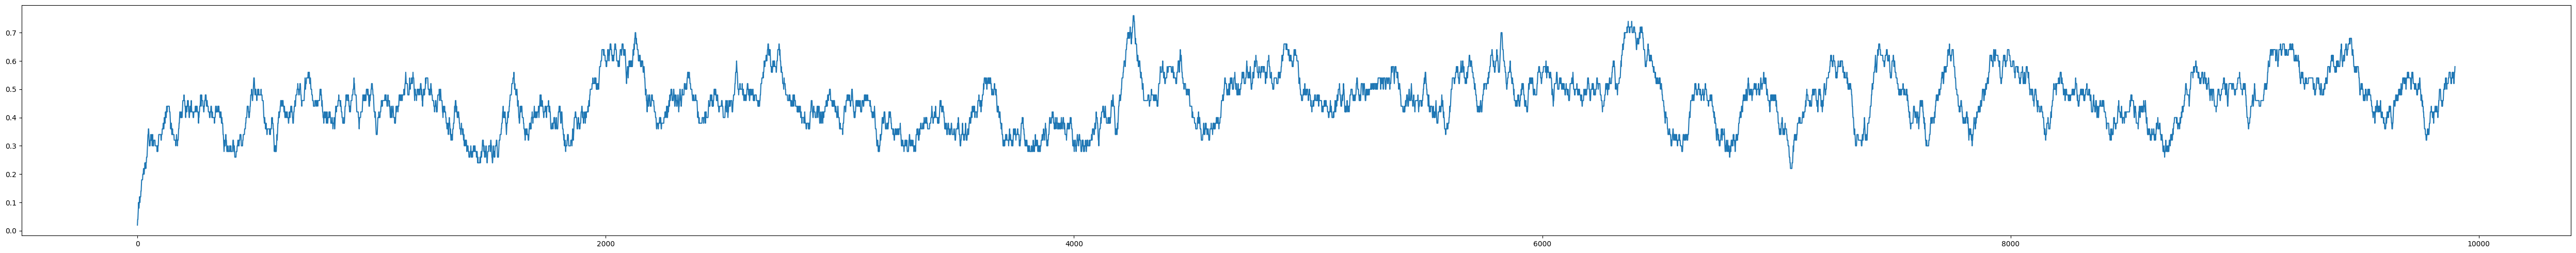

200


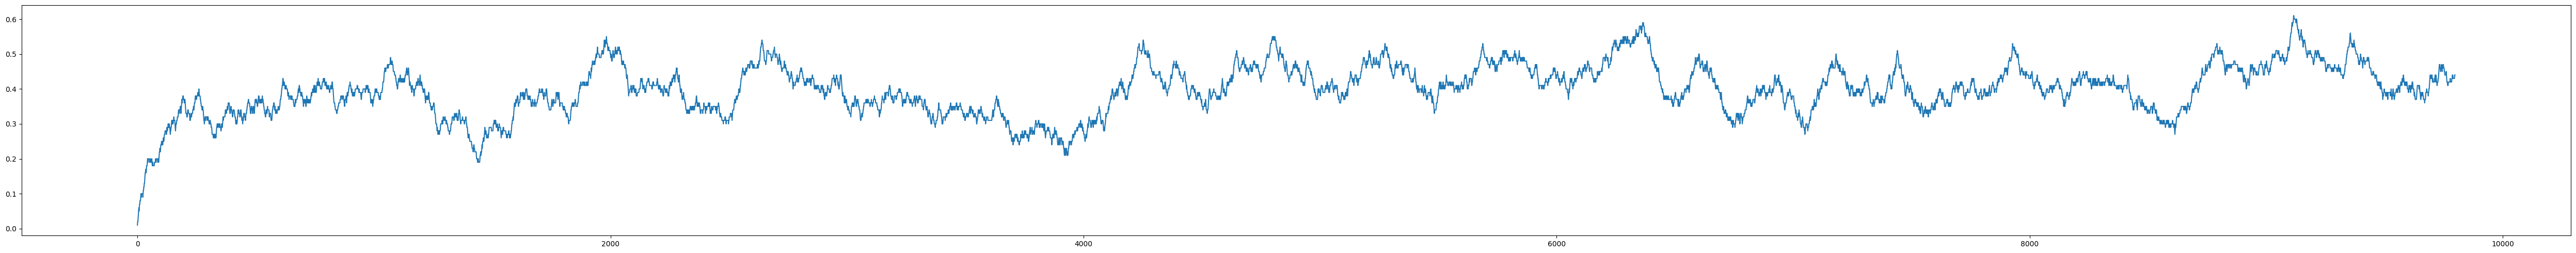

300


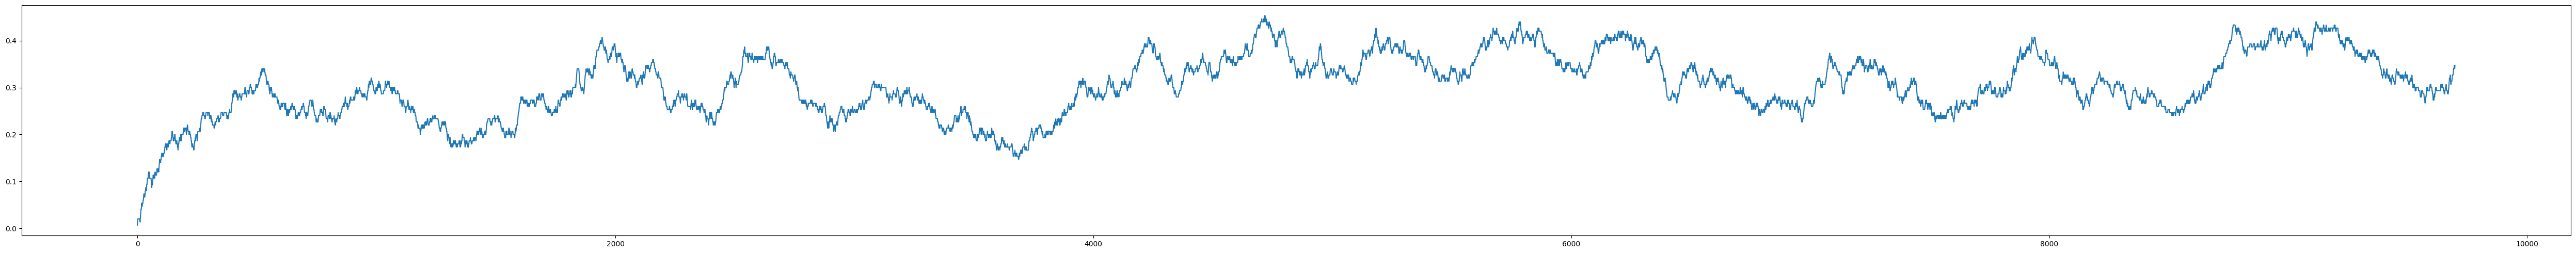

400


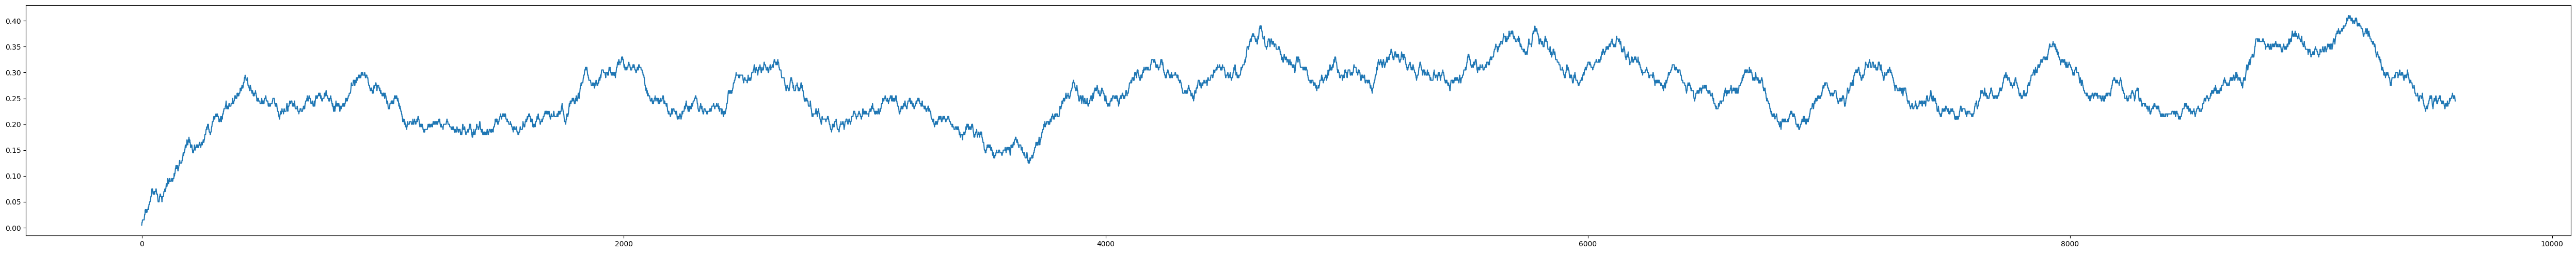

500


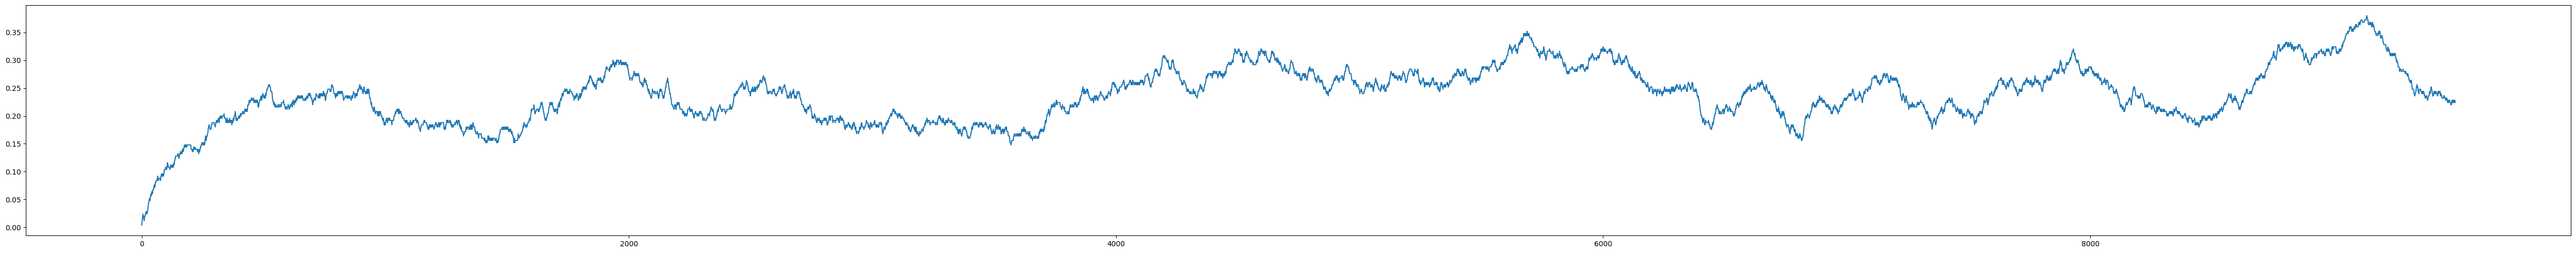

600


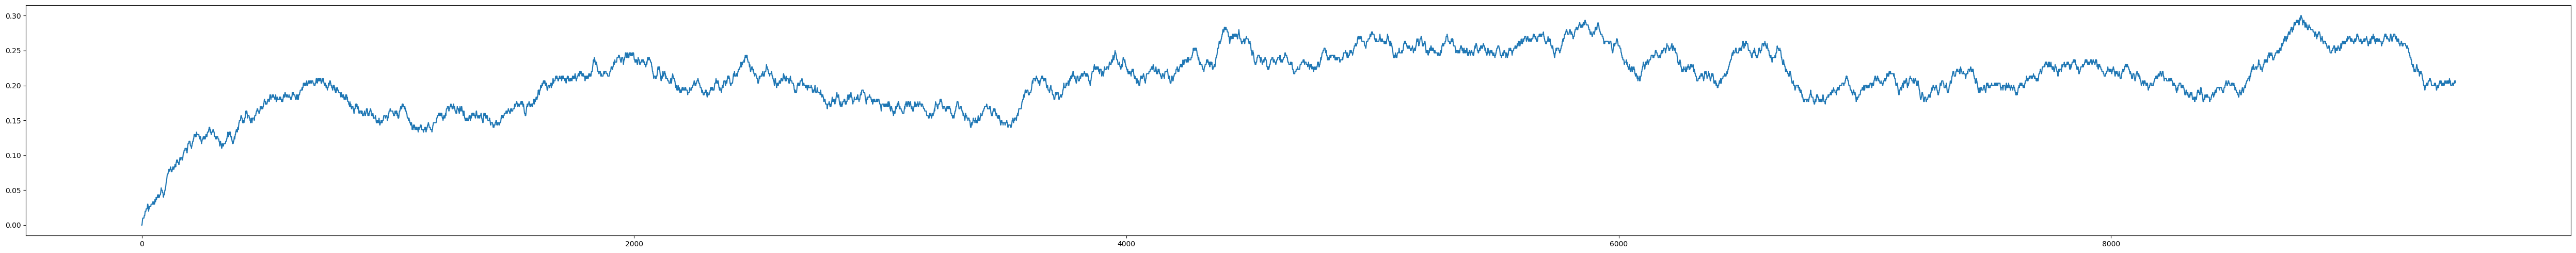

700


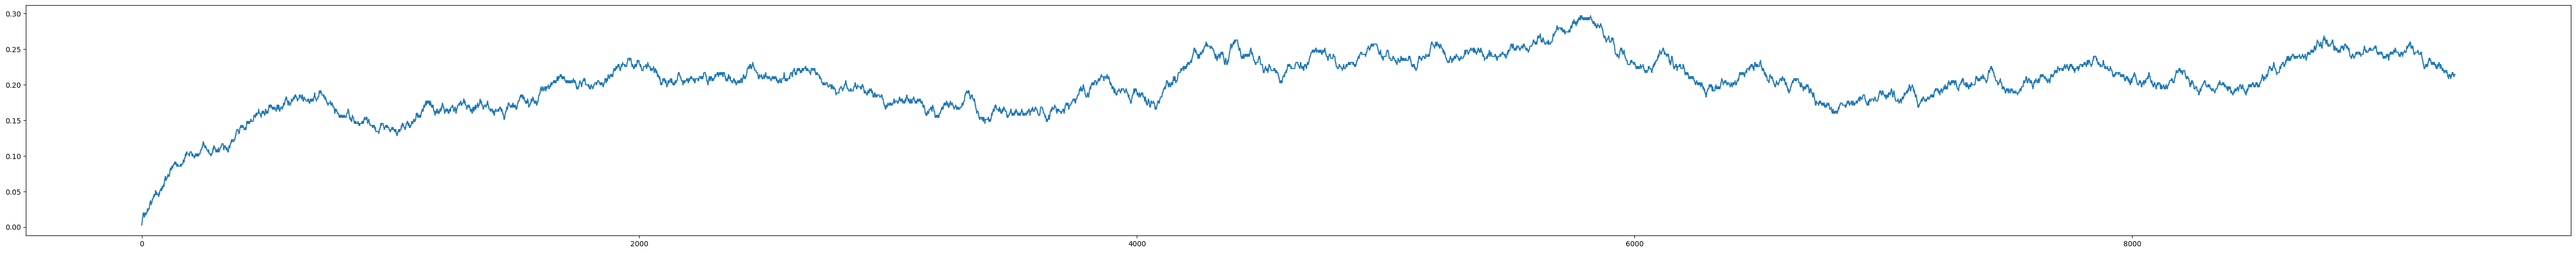

800


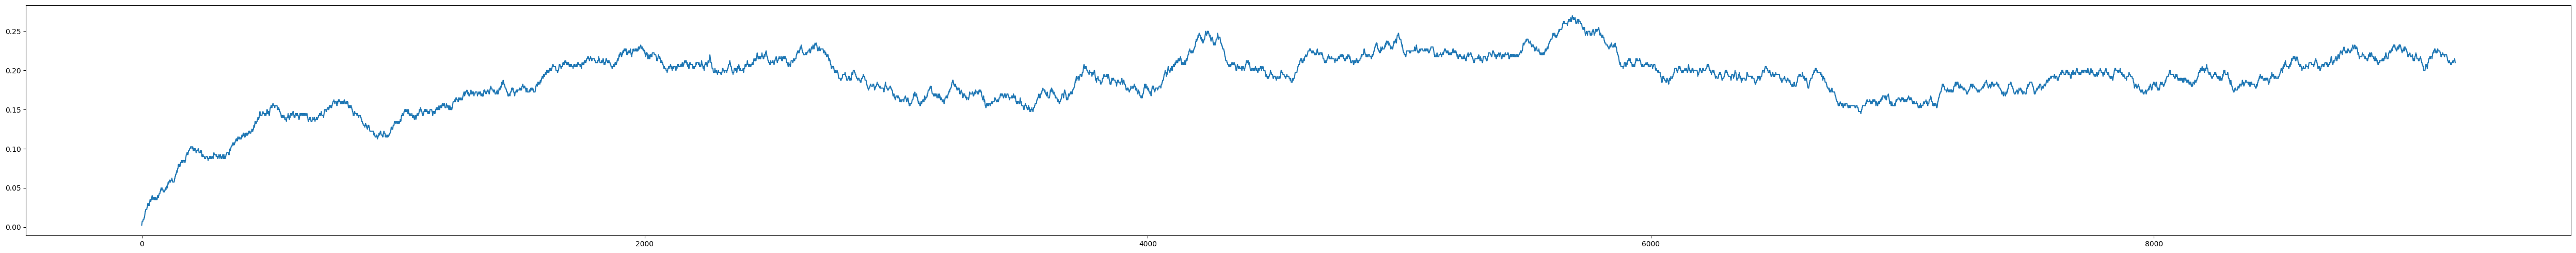

900


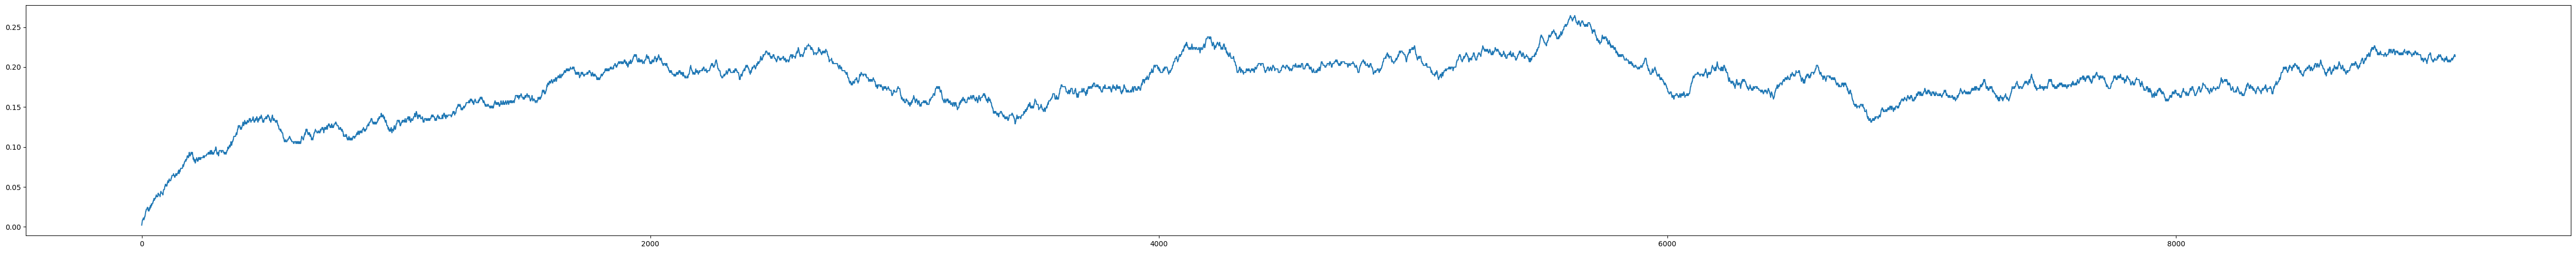

In [44]:
for bz in range(100, 1000, 100):
    print(bz)
    T = divide_via_distribution(input=input_str, buffer_size=bz)
    plot_T(T)

In [45]:
def get_substrings(T:list, input:list):
    substrings: dict[str, int] = {}
    buffer = []

    for inp_idx, inp in enumerate(input):
        buffer.append(inp)

        if inp_idx == 0 or inp_idx == len(input) - 1:
            continue

        if T[inp_idx] < T[inp_idx - 1] and T[inp_idx] < T[inp_idx + 1]:
            substr = ''.join(buffer)

            substrings.setdefault(substr, 0)
            substrings[substr] += 1

            buffer = []

    # sort
    substrings = dict(sorted(substrings.items(), key=lambda item: item[1], reverse=True))

    return substrings


In [46]:
def plot_T_with_symbols(T:list, inputs: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)
    axs.xaxis.set_ticks(np.arange(len(inputs)), inputs)
    axs.xaxis.grid(True)

    plt.show()

In [47]:
# plot_T(T)

In [48]:
# for dr in range(1, 10):
#     decrease_rate = dr * 0.1
#     print(decrease_rate)
#     T = divide_via_trace(inputs=input_str, decrease_rate=decrease_rate)
#     plot_T(T)